In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.special import inv_boxcox, boxcox1p
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
%matplotlib inline

##############################################
## HELPER FUNCTIONS
##############################################
# box-cox transformation
def BoxCox(x, lmbda):
    y, boxcox_lmbda = stats.boxcox(y_train, lmbda=None)
    return (y, boxcox_lmbda)

# inverce box-cox transformation
def BoxCoxInv(x, lmbda):
    return inv_boxcox(x, lmbda)

# change dtype of the columns
def ChangeDTypeOfColumns(df, cols, new_dtype):
    for col in cols:
        df.loc[:,col] = df[col].astype(new_dtype)
    return df
        
# fill NULLs with medians from X_train
def FillNaWithMedian(df, cols):
    for col in cols:
        df.loc[:,col] = df[col].fillna(X_train[col].median())
    return df[cols]

# log transformation
LogTransform = lambda x: np.log1p(x)

# reverse log transformation
LogTransformInv = lambda x: np.exp(x)

# tranform to bool
BoolTransfrom = lambda x: 1 if x > 0 else 0

# calculate one-way ANOVA
def CalculateAnova(df, col, target):
    groups = list(df[col].unique())
    anova = []
    for group in groups:
        anova.append(list(df[df[col].apply(lambda x: str(group) in str(x))][target].values))
    return f_oneway(*anova)[1]  # return anova p-value

# label encoding based on median values
def MapSingleFeature(xy, col):
    encoding = pd.DataFrame()
    encoding.loc[:,'values'] = xy[col].unique().copy()
    encoding.index = encoding['values']
    encoding.loc[:,'med'] = xy[[col, 'SalePrice']].groupby(col).median()['SalePrice'].copy()
    encoding = encoding.sort_values('med')
    encoding['ordering'] = range(1, encoding.shape[0]+1)
    mapping = encoding['ordering'].to_dict()
    return (col, mapping)

# prepares X and y data frames from Xy
def Prepare_X_and_y(Xy, target_col):
    X = Xy.drop(target_col, axis=1).copy()
    y = Xy[target_col].copy()
    return (X, y)
    
# prepares Xy data frame from X and y
def Prepare_Xy(X, y, target_col):
    Xy = X.copy()
    Xy[target_col] = y.copy()
    return Xy

# prepares Xy_train from X_all
def Prepare_Xy_from_X_all(x):
    return pd.merge(X_all[X_all['source'] == 'train'], y, on='Id', how='left').copy()

# train model and make prediction
def TrainModelAndMakePrediction(estimator,
                                param_grid,
                                X_train,
                                y_train,
                                X_test,
                                y_test,
                                #BoxCoxInv_fun,
                                #boxcox_lmbda,
                                cv):
    model = GridSearchCV(estimator, param_grid, cv=cv)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    #prediction = BoxCoxInv(prediction, BOXCOX_LMBDA)
    prediction = LogTransformInv(prediction)
    return (prediction, model)

# calculate error accorting to Kaggle competition rules
def CalculateError(true, predicted):
    true = np.log(true)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(predicted-true))/len(true))

# model validation
def ValidateModel(true, predicted, CalculateError_fun):
    r2 = r2_score(true, predicted)
    error = CalculateError_fun(true, predicted)
    print 'R2: %.2f\nError: %.5f' %(r2, error)

# tree-based feature selection
def TreeBasedFeatureSelection(X_train, y_train, top):
    etr = ExtraTreesRegressor(n_estimators=30)
    etr = etr.fit(X_train, y_train)
    important_features = pd.DataFrame({'feature': X_train.columns,
                                       'importance': etr.feature_importances_})
    important_features = important_features.sort_values('importance', ascending=False)
    return important_features[0:top]

In [3]:
##############################################
## DATA LOADING
##############################################
# load
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# create X and y for train
X = train.drop('SalePrice', axis=1).copy()
y = train['SalePrice'].copy()

In [4]:
## OUTLIERS (Removing obvious ones)
# based on http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt
Xy = Prepare_Xy(X, y, 'SalePrice')
Xy.drop(Xy[(Xy.loc[:,'GrLivArea'] > 4000) & (Xy.loc[:,'SalePrice'] < 300000)].index, axis=0, inplace=True)
X, y = Prepare_X_and_y(Xy, 'SalePrice')

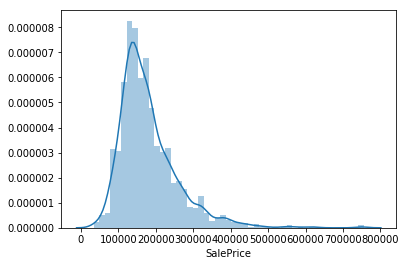

In [5]:
## TARGET VARIABLE
sns.distplot(y)

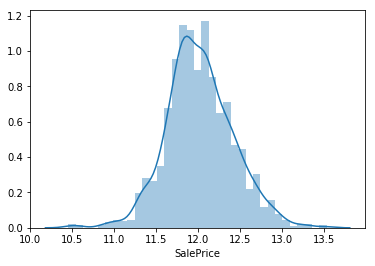

In [6]:
# looks like good candidate for log or box-cox transformation
#y_train, BOXCOX_LMBDA = BoxCox(x=y_train, lmbda=None)
y = LogTransform(y).copy()
sns.distplot(y)

In [7]:
## CREATE DATASETS
# add Id's to y
y = Prepare_Xy(X, y, 'SalePrice')[['Id', 'SalePrice']].copy()

# X_all creation for data preparation
X.loc[:,'source'] = 'train'
test.loc[:,'source'] = 'test'
X_all = pd.concat([X, test]).reset_index(drop=True)

TO_SKIP = ['Id', 'source']

In [8]:
##############################################
## DATA PREPARATION
##############################################
## Missing data
nulls = pd.DataFrame({'null_count': X_all.isnull().sum(),
                      'null_percent': X_all.isnull().sum() / X_all.shape[0] * 100})
# drop columns with more than 80% of nulls
null_cols_to_drop = list(nulls[nulls['null_percent'] > 80].index)
X_all.drop(null_cols_to_drop, axis=1, inplace=True)

# null columns to check during later analysis
# possible actions:
# - remove feature and do not bother about nulls
# - fill with aggregated value (mean, median, ...)
# - fill with 0.0
# - fill with "NA" for categorical data
# - fill with meaningful value
NULL_COLS_TO_CHECK = [c for c in list(nulls[nulls['null_count'] != 0].index) if c not in TO_SKIP + null_cols_to_drop]

In [9]:
## Drop unnecessary features
X_all.drop('MoSold', axis=1, inplace=True)

## Transform qualitative features to quantitative
COLS_TO_QUALITATIVE = 'MSSubClass, OverallCond, YearBuilt, YearRemodAdd, YrSold, GarageYrBlt'.split(', ')
X_all = ChangeDTypeOfColumns(X_all, COLS_TO_QUALITATIVE, 'object')

QUANTITATIVE = [c for c in list(X_all._get_numeric_data().columns) if c not in TO_SKIP]
QUALITATIVE = [c for c in list(X_all.columns) if c not in QUANTITATIVE + TO_SKIP]

In [10]:
## Input missing values for QUALITATIVE
# approach is to fill with:
# - 'NA'
# - most frequent value
# - value derived from data description
X_all['MSZoning'].fillna(X_all['MSZoning'].mode()[0], inplace=True)
X_all['Utilities'].fillna(X_all['Utilities'].mode()[0], inplace=True)
X_all['Exterior1st'].fillna(X_all['Exterior1st'].mode()[0], inplace=True)
X_all['Exterior2nd'].fillna(X_all['Exterior2nd'].mode()[0], inplace=True)
X_all['MasVnrType'].fillna('NA', inplace=True)
X_all['BsmtQual'].fillna('NA', inplace=True)
X_all['BsmtCond'].fillna('NA', inplace=True)
X_all['BsmtExposure'].fillna('NA', inplace=True)
X_all['BsmtFinType1'].fillna('NA', inplace=True)
X_all['BsmtFinType2'].fillna('NA', inplace=True)
X_all['Electrical'].fillna(X_all['Electrical'].mode()[0], inplace=True)
X_all['KitchenQual'].fillna(X_all['KitchenQual'].mode()[0], inplace=True)
X_all['Functional'].fillna('Typ', inplace=True)
X_all['FireplaceQu'].fillna('NA', inplace=True)
X_all['GarageType'].fillna('NA', inplace=True)
X_all['GarageFinish'].fillna('NA', inplace=True)
X_all['GarageQual'].fillna('NA', inplace=True)
X_all['GarageCond'].fillna('NA', inplace=True)
X_all['SaleType'].fillna(X_all['SaleType'].mode()[0], inplace=True)

In [11]:
## Input missing values for QUANTITATIVE
# approach is to fill with:
# - 0
# - median value
X_all['LotFrontage'] = X_all.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
X_all['MasVnrArea'].fillna(0, inplace=True)
X_all['BsmtFinSF1'].fillna(0, inplace=True)
X_all['BsmtFinSF2'].fillna(0, inplace=True)
X_all['BsmtUnfSF'].fillna(0, inplace=True)
X_all['TotalBsmtSF'].fillna(0, inplace=True)
X_all['BsmtFullBath'].fillna(0, inplace=True)
X_all['BsmtHalfBath'].fillna(0, inplace=True)
X_all['GarageCars'].fillna(0, inplace=True)
X_all['GarageArea'].fillna(0, inplace=True)
X_all['GarageYrBlt'].fillna(0, inplace=True)

In [12]:
## transform years to bins
bins = [0, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 9999]
labels = ['-1900', '1900s', '1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2010-']

def TransformYearsToBins(x, col):
    x.loc[:,col] = pd.cut(x[col], bins, labels).astype(str).apply(lambda x: x[1:-1])
    x.loc[:,col] = x[col].apply(lambda x: 'NA' if x == 'a' else x)
    return x[col].copy()

X_all.loc[:,'YearBuilt'] = TransformYearsToBins(X_all, 'YearBuilt')
X_all.loc[:,'YearRemodAdd'] = TransformYearsToBins(X_all, 'YearRemodAdd')
X_all.loc[:,'YrSold'] = TransformYearsToBins(X_all, 'YrSold')
X_all.loc[:,'GarageYrBlt'] = TransformYearsToBins(X_all, 'GarageYrBlt')

/Users/slechwar/miniconda2/lib/python2.7/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


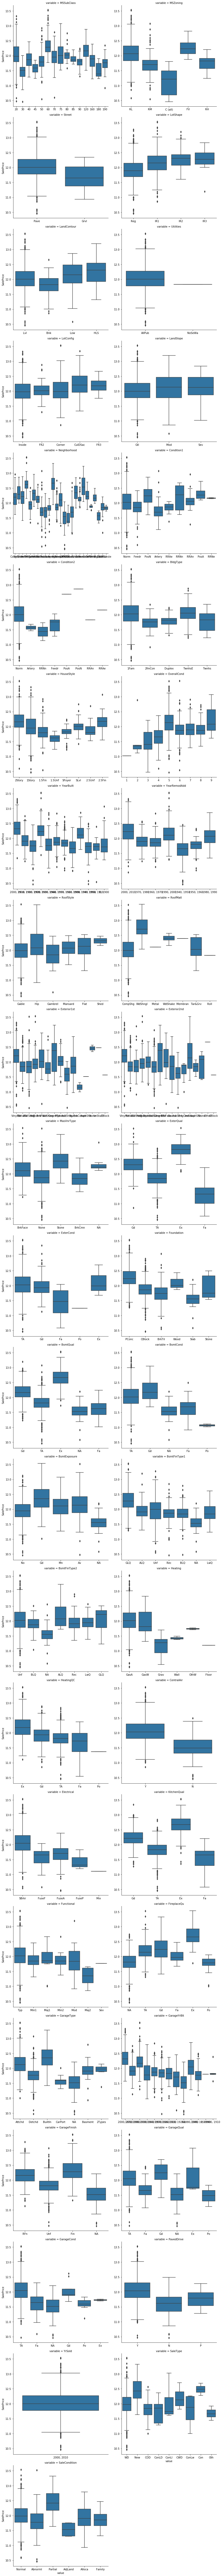

In [13]:
# plot box plots: SalePrice distribution per category
Xy = Prepare_Xy_from_X_all(X_all)

melted = Xy[QUALITATIVE + ['SalePrice']].melt(id_vars='SalePrice').copy()
g = sns.FacetGrid(data=melted, col='variable', col_wrap=2, size=6, sharex=False, sharey=False)
g.map(sns.boxplot, 'value', 'SalePrice')

In [14]:
# ANOVA
# some features may influance SalePrice more than others 
# compute one-way ANOVA to find out if average of more than two groups is statistically different
anova = []
for col in QUALITATIVE:
    tmp = (col, CalculateAnova(Xy, col, 'SalePrice'))
    anova.append(tmp)

anova = pd.DataFrame(anova)
anova.columns = ['feature', 'p_value']
anova.sort_values(by='p_value').head(10)

/Users/slechwar/miniconda2/lib/python2.7/site-packages/scipy/stats/stats.py:2924: RuntimeWarning: invalid value encountered in double_scalars
  msb = ssbn / float(dfbn)


,feature,p_value
8,Neighborhood,7.272119e-237
21,ExterQual,2.866856e-197
24,BsmtQual,6.791010e-190
33,KitchenQual,1.637677e-188
14,YearBuilt,6.222467e-156
38,GarageFinish,3.152865e-151
37,GarageYrBlt,7.206824e-147
36,GarageType,8.471072e-125
35,FireplaceQu,6.914417e-115
15,YearRemodAdd,1.092393e-114


In [15]:
# do we have features with anova p_value > 0.5
anova_to_drop = anova[anova['p_value'] > 0.5]  # yes
anova_to_drop = anova_to_drop['feature'].tolist()
X_all.drop(anova_to_drop, axis=1, inplace=True)
QUALITATIVE = [c for c in QUALITATIVE if c not in anova_to_drop]

In [16]:
# FEATURE ENCODING
# - One-hot encoding
ONE_HOT_ENCODING = 'Street, LandSlope'.split(', ')
# - Label encoding
LABEL_ENCODING = [c for c in QUALITATIVE if c not in ONE_HOT_ENCODING]
X_all = pd.get_dummies(data=X_all, columns=ONE_HOT_ENCODING)

In [17]:
# Label encoding
Xy = Prepare_Xy_from_X_all(X_all)
# create mappings
MAPPINGS = []
for col in LABEL_ENCODING:
    mapping = MapSingleFeature(Xy, col)
    MAPPINGS.append(mapping)
# map features
for col in LABEL_ENCODING:
    for c, mapping in MAPPINGS:
        if c == col:
            X_all.loc[:,c] = X_all[c].map(mapping)

# deal with not mapped rows
X_all['MSSubClass'].fillna(X_all['MSSubClass'].median(), inplace=True)
X_all['GarageYrBlt'].fillna(X_all['GarageYrBlt'].median(), inplace=True)

/Users/slechwar/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/slechwar/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/slechwar/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


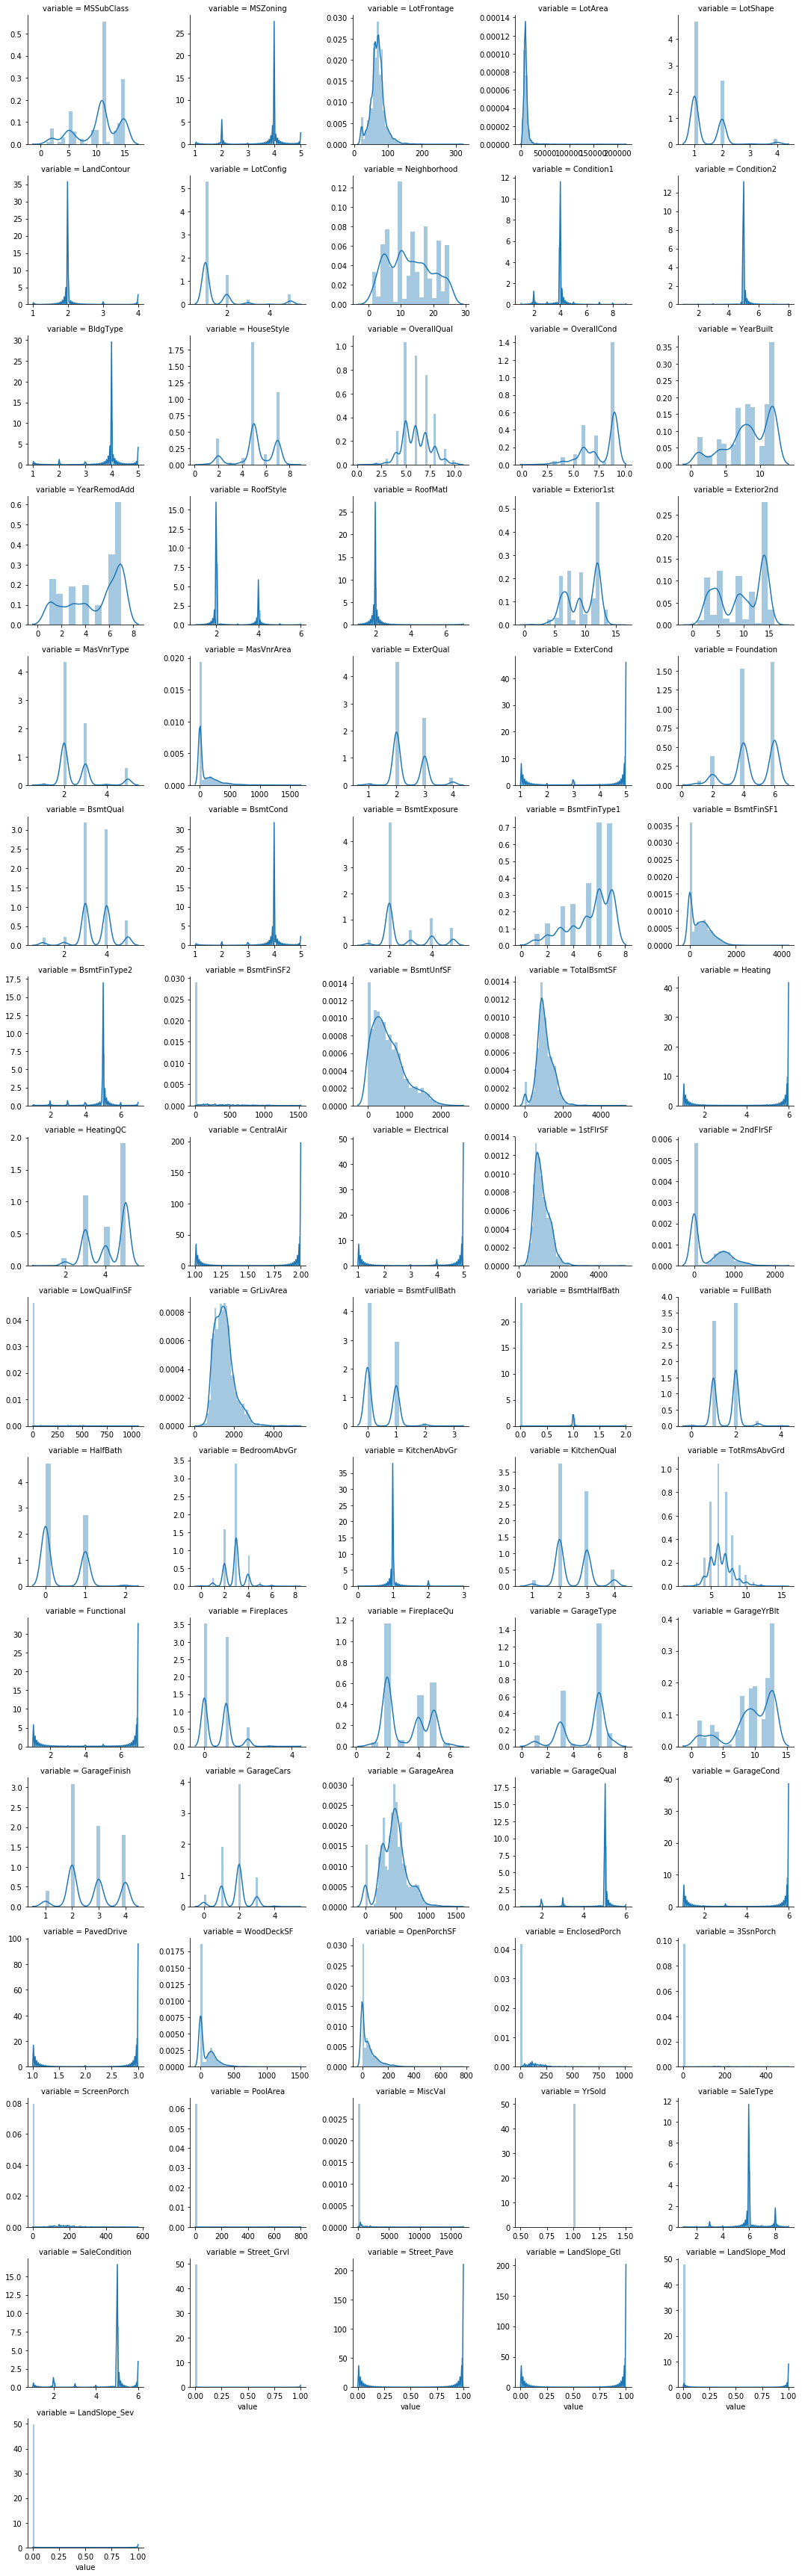

In [18]:
## QUANTITATIVE DATA
QUANTITATIVE = [c for c in list(X_all._get_numeric_data().columns) if c not in TO_SKIP]

# display many distributions as FacetGrid
melted = pd.melt(X_all, value_vars=QUANTITATIVE).copy()
g = sns.FacetGrid(melted, col='variable', col_wrap=5, sharex=False, sharey=False)
g.map(sns.distplot, 'value')

In [19]:
# conclusions
# some highly skewed features needs to be transformed (box-cox)
# some features can be transform to boolean
# new features can be created

In [20]:
# transform skewed features
skew = []
for c in QUANTITATIVE:
    skew.append((c, abs(stats.skew(X_all[c]))))
skew = pd.DataFrame(skew)
skew.columns = ['feature', 'skewness']
skew.sort_values(by='skewness', ascending=False)
SKEWED = skew[skew['skewness'] > 0.75]['feature'].tolist()

lmbda = 0.15
for c in SKEWED:
    X_all.loc[:,c] = boxcox1p(X_all[c], lmbda)

In [21]:
# transform to boolean
X_all.loc[:,'Has_MasVnr'] = X_all['MasVnrArea'].apply(BoolTransfrom)
X_all.loc[:,'Has_Bsmt'] = X_all['TotalBsmtSF'].apply(BoolTransfrom)
X_all.loc[:,'Has_2ndFlr'] = X_all['2ndFlrSF'].apply(BoolTransfrom)
X_all.loc[:,'Has_LowQualFin'] = X_all['LowQualFinSF'].apply(BoolTransfrom)
X_all.loc[:,'Has_Fireplace'] = X_all['Fireplaces'].apply(BoolTransfrom)
X_all.loc[:,'Has_Garage'] = X_all['GarageArea'].apply(BoolTransfrom)
X_all.loc[:,'Has_WoodDeck'] = X_all['WoodDeckSF'].apply(BoolTransfrom)
X_all.loc[:,'Has_OpenPorch'] = X_all['OpenPorchSF'].apply(BoolTransfrom)
X_all.loc[:,'Has_EnclosedPorch'] = X_all['EnclosedPorch'].apply(BoolTransfrom)
X_all.loc[:,'Has_3SsnPorch'] = X_all['3SsnPorch'].apply(BoolTransfrom)
X_all.loc[:,'Has_ScreenPorch'] = X_all['ScreenPorch'].apply(BoolTransfrom)
X_all.loc[:,'Has_PoolArea'] = X_all['PoolArea'].apply(BoolTransfrom)

BOOLEAN = [c for c in list(X_all.columns) if c[0:4] == 'Has_']

/Users/slechwar/miniconda2/lib/python2.7/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


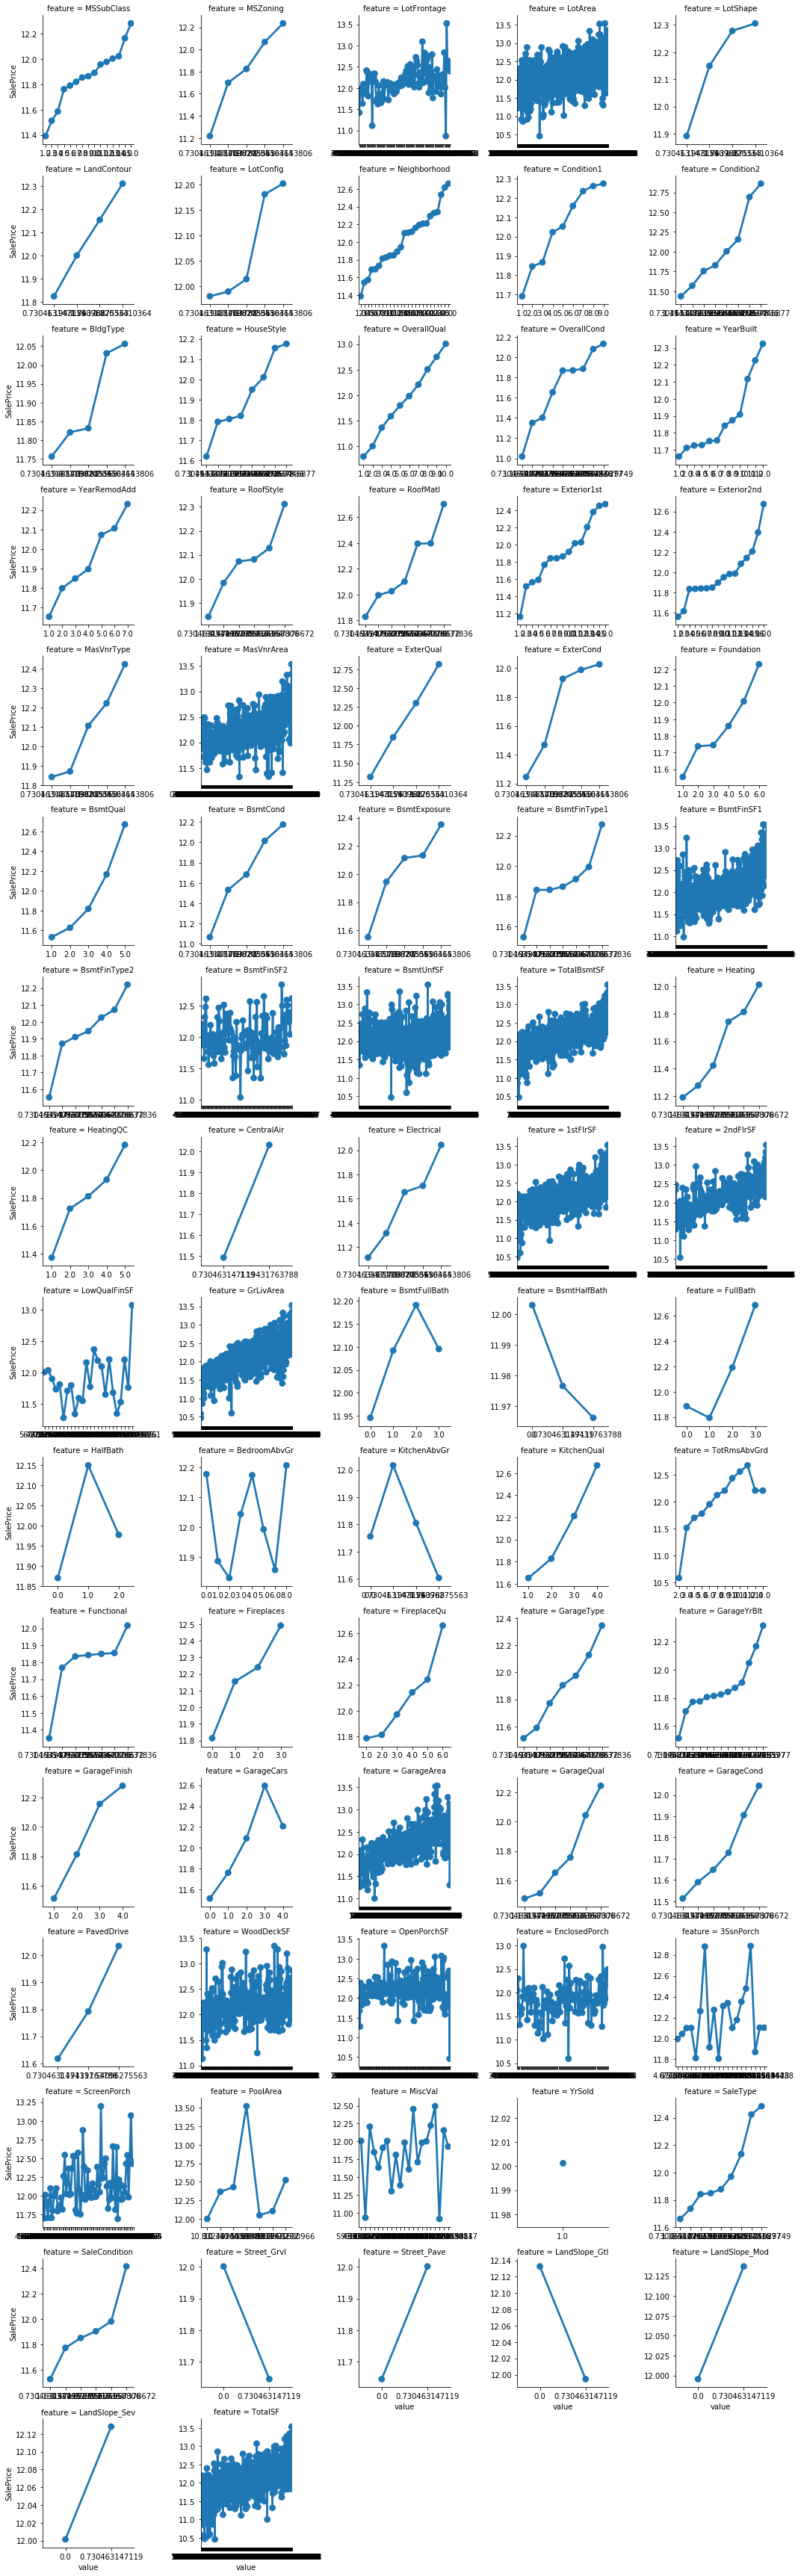

In [22]:
## CREATE NEW FEATURES
X_all.loc[:,'TotalSF'] = X_all.loc[:,'TotalBsmtSF'] + X_all.loc[:,'1stFlrSF'] + X_all.loc[:,'2ndFlrSF']

# check quantitative vs target
# I would like to check relations between qualitative values and descriptive value
# maybe there are some non-linear relations
QUANTITATIVE = [c for c in list(X_all._get_numeric_data().columns) if c not in TO_SKIP + BOOLEAN]

Xy = Prepare_Xy_from_X_all(X_all)
for_plot = pd.DataFrame({'value': [], 'SalePrice': [], 'feature': []})
for col in QUANTITATIVE:
    tmp = Xy[[col,'SalePrice']].groupby(col).median().copy()
    tmp['feature'] = tmp.index.name
    tmp.reset_index(inplace=True)
    tmp.columns = ['value', 'SalePrice', 'feature']
    for_plot = pd.concat([for_plot, tmp])

g = sns.FacetGrid(for_plot, col='feature', col_wrap=5, sharex=False, sharey=False)
g.map(sns.pointplot, 'value', 'SalePrice')

In [23]:
COLS_TO_QUADRATIC_TERM = 'LotShape, LotConfig, Neighborhood, Condition1, Condition2, YearBuilt, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, ExterCond, BsmtQual, BsmtExposure, BsmtFinType1, 2ndFlrSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Functional, FireplaceQu, GarageYrBlt, GarageFinish, GarageQual, GarageCond, OpenPorchSF, PoolArea, SaleType, SaleCondition, TotalSF'.split(', ')
COLS_TO_CUBIC_TERM = 'LotConfig, YearBuilt, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, BsmtExposure, BsmtFinType1, 2ndFlrSF, BedroomAbvGr, TotRmsAbvGrd, Functional, GarageYrBlt, PoolArea'.split(', ')

# add higher order features
def ToHigherOrderTerms(x, col_quad, col_qubic):
    for col in col_quad:
        x.loc[:,col + '_quad'] = x[col].apply(lambda x: np.power(x, 2))
    for col in col_qubic:
        x.loc[:,col + '_cubic'] = x[col].apply(lambda x: np.power(x, 3))
    return x

X_all = ToHigherOrderTerms(X_all, COLS_TO_QUADRATIC_TERM, COLS_TO_CUBIC_TERM)

In [24]:
## FEATURE SCALING
QUANTITATIVE = list(X_all._get_numeric_data().columns)
FEATURE_SCALING = [c for c in QUANTITATIVE if c not in TO_SKIP + BOOLEAN + ONE_HOT_ENCODING + LABEL_ENCODING]
#scaler = StandardScaler()
scaler = RobustScaler()

def FeatureScaling(x, cols, scaler):
    x.loc[:,x[cols].columns] = scaler.fit_transform(x[cols]).copy()
    return x

# decide if feature scaling should be used
X_all = FeatureScaling(X_all, FEATURE_SCALING, scaler)

In [25]:
## OUTLIERS DETECTION ON WHOLE DATASET
OUTLIER_DETECTION = [c for c in QUANTITATIVE if c not in TO_SKIP]
lof = LocalOutlierFactor(n_neighbors=200)

# remove data only from train samples
trn = X_all[X_all['source'] == 'train'].copy()

trn.loc[:,'is_inlier'] = lof.fit_predict(trn[OUTLIER_DETECTION])
trn['is_inlier'].value_counts()[-1]
index_to_drop = trn[trn['is_inlier'] == -1].index.tolist()

# remove or not
X_all.drop(index_to_drop, axis=0, inplace=True)

In [26]:
##############################################
## DATA MODELLING
##############################################
# create datasets
X_test = X_all[X_all['source'] == 'test'].copy()
X_test.drop('source', axis=1, inplace=True)

Xy_train_and_valid = pd.merge(X_all, y, on='Id', how='inner').copy()
X_train_and_valid, y_train_and_valid = Prepare_X_and_y(Xy_train_and_valid, 'SalePrice')
X_train_and_valid.drop('source', axis=1, inplace=True)

# split to train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=0.1, random_state=104)

In [27]:
# select no. features for the model

#important_features = TreeBasedFeatureSelection(X_train, y_train, 66)
important_features = TreeBasedFeatureSelection(X_train, y_train, X_train.shape[1])  # all

not_important_features = [c for c in X_train.columns if c not in list(important_features['feature'])]
X_train = X_train.drop(not_important_features, axis=1).copy()
X_valid = X_valid.drop(not_important_features, axis=1).copy()
X_test = X_test.drop(not_important_features, axis=1).copy()

In [698]:
# Lasso, Ridge, ElasticNet
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1,],
    #'l1_ratio': [0.005, 0.05, 0.5, 5],  # for ElasticNet
    'normalize': [False, True],
}
lasso = Lasso()
ridge = Ridge()
elastic_net = ElasticNet()

In [30]:
# ExtraTreesRegressor
param_grid = {
    'n_estimators': [50],
    'criterion': ['mse'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [False]
}
etr = ExtraTreesRegressor(n_estimators=30)

In [28]:
# XGBboost
from xgboost import XGBRegressor

param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.01, 0.1],
    'n_estimators': [300]
}
xgb = XGBRegressor()

/Users/slechwar/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
%%time
# train model and make prediction
prediction, model = TrainModelAndMakePrediction(estimator=xgb,
                                                param_grid=param_grid,
                                                X_train=X_train,
                                                y_train=y_train,
                                                X_test=X_valid,
                                                y_test=y_valid,
                                                #BoxCoxInv_fun=BoxCoxInv,
                                                #boxcox_lmbda=BOXCOX_LMBDA,
                                                cv=150)

CPU times: user 50min 8s, sys: 40.2 s, total: 50min 48s
Wall time: 6min 32s


In [30]:
ValidateModel(LogTransformInv(y_valid), prediction, CalculateError)

R2: 0.91
Error: 0.10329


Text(0,0.5,u'true - prediction')

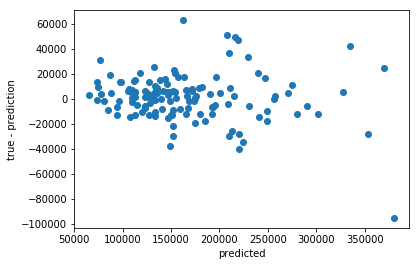

In [31]:
plt.scatter(prediction, LogTransformInv(y_valid) - prediction)
plt.xlabel('predicted')
plt.ylabel('true - prediction')

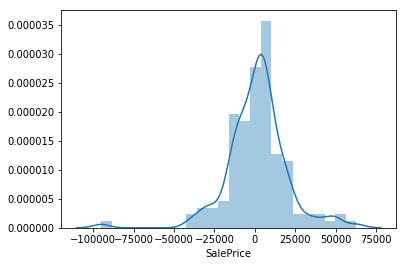

In [32]:
# distplot of residuals
sns.distplot(LogTransformInv(y_valid) - prediction)

In [33]:
##############################################
## RESULTS ON VALIDATION SAMPLE
##############################################
# 01: R2: 0.73, E: 0.21253 (Lasso, all features, no scaling, outliers removal, 70-30 split)
# 02: R2: 0.89, E: 0.13655 (Ridge, all features, no scaling, outliers removal, 70-30 split)
# 03: R2: 0.88, E: 0.14160 (ElasticNet, all features, no scaling, outliers removal, 70-30 split)
# 04: R2: 0.90, E: 0.12991 (ElasticNet, all features, no scaling, outliers removal, 80-20 split)
# 05: R2: 0.88, E: 0.13607 (ElasticNet, selected 75 features, no scaling, outliers removal, 80-20 split)
# 06: R2: 0.91, E: 0.12875 (Ridge, selected 75 features, no scaling, outliers removal, 80-20 split)
# 07: R2: 0.81, E: 0.16876 (Ridge, selected 32 features, no scaling, outliers removal, 80-20 split)
# 08: R2: 0.92, E: 0.12629 (Ridge, selected 216 features, no scaling, outliers removal, 80-20 split)
# 09: R2: 0.91, E: 0.12935 (Ridge, selected 150 features, no scaling, outliers removal, 80-20 split)
# 10: R2: 0.88, E: 0.14115 (Ridge, selected 150 features, scaling, outliers removal, 90-10 split)
# 11: R2: 0.86, E: 0.14351 (ElasticNet, selected 150 features, scaling, outliers removal, 90-10 split)
# 12: R2: 0.86, E: 0.14229 (ElasticNet, all features, scaling, outliers removal, 90-10 split)
# 13: R2: 0.88, E: 0.13375 (ElasticNet, all features, scaling, without outliers removal, 90-10 split)
# 14: R2: 0.90, E: 0.13024 (ElasticNet, all features, scaling, some outliers removal, 90-10 split)
# 15: R2: 0.88, E: 0.13375 (ElasticNet, all features + TotalSF, scaling, without outliers removal, 90-10 split)
# 16: R2: 0.92, E: 0.12714 (ElasticNet, all features + TotalSF, scaling, some outliers removal, 90-10 split)  [best on test]
# 17: R2: 0.91, E: 0.13226 (ElasticNet, all features + TotalSF + encoding, scaling, some outliers removal, 90-10 split)
# 18: R2: 0.82, E: 0.16648 (XGB, all features + TotalSF + encoding, scaling, some outliers removal, 90-10 split)
# 19: R2: 0.84, E: 0.16332 (XGB, all features + TotalSF + encoding, scaling, without outliers removal, 90-10 split)
# 20: R2: 0.86, E: 0.14072 (ElasticNet, changed exec order, all features + TotalSF + better encoding, scaling, without outliers removal, 90-10 split) ## changed exec order + new encoding
# 21: R2: 0.90, E: 0.13635 (Lasso, all features, no drops of boolean, no scaling, no outliers removal, 90-10 split)
# 22: R2: 0.88, E: 0.13550 (Ridge, all features, no drops of boolean, scaling, no outliers removal, 90-10 split)
# 23: R2: 0.90, E: 0.12970 (Ridge, all features, no drops of boolean, scaling, outliers removal, 90-10 split)
# 24: R2: 0.90, E: 0.13219 (ElasticNet, all features, no drops of boolean, scaling, outliers removal, 90-10 split)
# 25: R2: 0.88, E: 0.12413 (ElasticNet, 95 features, no drops of boolean, scaling, no outliers removal, 90-10 split) ## changed exec order once again + better NULL handling and feature eng.
# 26: R2: 0.90, E: 0.11822 (ElasticNet, all features, no drops of boolean, scaling, no outliers removal, 90-10 split)
# 29: R2: 0.91, E: 0.10329 (XGB, all features, no drops of boolean, scaling, outliers removal, 90-10 split)

In [34]:
##############################################
## CREATE EXTRACT FOR DATA SUBMISSION
##############################################
prediction = model.predict(X_test)
prediction = LogTransformInv(prediction)

subm = pd.DataFrame({
    'Id': X_test['Id'],
    'SalePrice': prediction})

subm.to_csv(path_or_buf='submissions/house_prices_submission_20180109_07.csv', sep=',', header=True, index=False)

In [ ]:
##############################################
## RESULTS ON TEST SAMPLE
##############################################
# 01: E: 0.14383 (Ridge, 150 features, no scaling, outliers removal, 80-20 split)
# 02: E: 0.14162 (Ridge, 150 features, scaling, outliers removal, 90-10 split)
# 03: E: 0.13830 (ElasticNet, 150 features, scaling, outliers removal, 90-10 split)
# 04: E: 0.13719 (ElasticNet, all features, scaling, outliers removal, 90-10 split)
# 05: E: 0.12970 (ElasticNet, all features, scaling, without outliers removal, 90-10 split)
# 06: E: 0.13169 (ElasticNet, all features, scaling, some outliers removal, 90-10 split)
# 07: E: 0.12970 (ElasticNet, all features + TotalSF, scaling, without outliers removal, 90-10 split)
# 08: E: 0.12464 (ElasticNet, all features + TotalSF, scaling, some outliers removal, 90-10 split) [best]
# 09: E: 0.12893 (ElasticNet, all features + TotalSF + encoding, scaling, some outliers removal, 90-10 split)
# 09: E: 0.17735 (XGB, all features + TotalSF + encoding, scaling, some outliers removal, 90-10 split)
# 10: E: 0.17679 (ElasticNet, changed exec order, all features + TotalSF + better encoding, scaling, without outliers removal, 90-10 split)
# 11: E: 0.14844 #21
# 12: E: 0.17103 #22
# 13: E: 0.16667 #23
# 14: E: 0.13254 #25
# 15: E: 0.13179 #26
# 16: E: 0.13643 #27

In [ ]:
##############################################
## ADDITIONAL ANALYSIS
##############################################

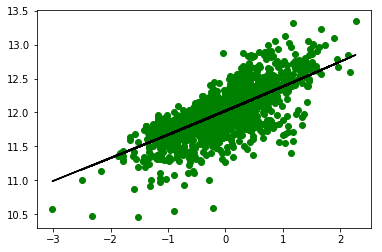

In [41]:
## FEATURE ENGINEERING
## NOTE: use for ad-hoc analysis, not needed for the script
Xy = Prepare_Xy_from_X_all(X_all)

col = 'GrLivArea'  # fill with column name to check
x = Xy[col].copy()
# add whatever you like :-)
X_tmp = pd.DataFrame({'x0': x
                      ,'x1': x**2
                      #,'x2': x**3
                      #'x0': np.log1p(x)
                      })
y_tmp = Xy['SalePrice'].copy()
ridge = Ridge()
param_grid = {'alpha': [0.1,1,10],
              'normalize': [True,False]}
model = GridSearchCV(ridge, param_grid, cv=100)
model.fit(X_tmp, y_tmp)

plt.scatter(X_tmp['x0'], y_tmp, color='g')
plt.plot(X_tmp['x0'], model.predict(X_tmp), color='k')

In [289]:
%%time
## FEATURE SELECTION
# iterate through feature selection to get no. features
errors = []
for f in range(1, X_train.shape[1]):
    important_features = TreeBasedFeatureSelection(X_train, y_train, f)
    not_important_features = [c for c in X_train.columns if c not in list(important_features['feature'])]

    X_train_new = X_train.drop(not_important_features, axis=1)
    X_valid_new = X_valid.drop(not_important_features, axis=1)

    prediction, model = TrainModelAndMakePrediction(estimator=xgb,
                                                    param_grid=param_grid,
                                                    X_train=X_train_new,
                                                    y_train=y_train,
                                                    X_test=X_valid_new,
                                                    y_test=y_valid,
                                                    #BoxCoxInv_fun=BoxCoxInv,
                                                    #boxcox_lmbda=BOXCOX_LMBDA,
                                                    cv=50)
    error = CalculateError(y_valid, prediction)
    errors.append((f, error))

CPU times: user 3h 21min 18s, sys: 13min 26s, total: 3h 34min 44s
Wall time: 29min 57s


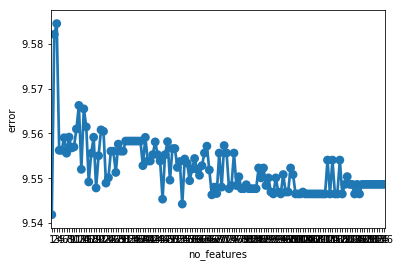

In [290]:
# plot error vs no. features
errors = pd.DataFrame(errors)
errors.columns = ['no_features', 'error']
sns.pointplot(x='no_features', y='error', data=errors)

In [291]:
errors.sort_values(by='error', ascending=True).head(20)

,no_features,error
0,1,9.541876
53,54,9.544263
45,46,9.545351
65,66,9.546314
118,119,9.546508
116,117,9.546508
115,116,9.546508
113,114,9.546508
111,112,9.546508
110,111,9.546508
